In [1]:
import os
from collections import defaultdict
import math
import numpy as np 
import re
import torch
import torch.nn as nn
from itertools import cycle
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torch.optim.lr_scheduler import MultiStepLR
from tqdm.auto import tqdm

# Used to get the data
from sklearn.metrics import ndcg_score

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
nltk.download('stopwords')

import matplotlib.pyplot as plt 
import matplotlib
matplotlib.use('Agg')


import pandas as pd

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
config = {}

config["dataset"] = "CNN" # "IMDB" "CNN", "PubMed"
config["n_document"] = 6852
config["normalize_word_embedding"] = True
config["min_word_freq_threshold"] = 20
config["topk_word_freq_threshold"] = 100
config["document_vector_agg_weight"] = 'IDF' # ['mean', 'IDF', 'uniform', 'gaussian', 'exponential', 'pmi']
config["select_topk_TFIDF"] = None
config["embedding_file"] = "/content/drive/MyDrive/ML/autoencoder/glove.6B.100d.txt"
config["topk"] = [10, 30, 50]

sk_lasso_epoch = 10000
our_lasso_epoch = 50000
is_notebook = True

In [6]:
# load word embedding
embedding_file = config["embedding_file"]
word2embedding = dict()
word_dim = int(re.findall(r".(\d+)d",embedding_file)[0])

with open(embedding_file,"r") as f:
    for line in tqdm(f):
        line = line.strip().split()
        word = line[0]
        embedding = list(map(float,line[1:]))
        word2embedding[word] = np.array(embedding)

print("Number of words:%d" % len(word2embedding))

0it [00:00, ?it/s]

Number of words:400000


In [7]:
def normalize_wordemb(word2embedding):
    word_emb = []
    word_list = []
    for word, emb in word2embedding.items():
        word_list.append(word)
        word_emb.append(emb)

    word_emb = np.array(word_emb)

    for i in range(len(word_emb)):
        norm = np.linalg.norm(word_emb[i])
        word_emb[i] = word_emb[i] / norm

    for word, emb in tqdm(zip(word_list, word_emb)):
        word2embedding[word] = emb
    return word2embedding

if config["normalize_word_embedding"]:
    normalize_wordemb(word2embedding)

0it [00:00, ?it/s]

In [8]:
class Vocabulary:
    def __init__(self, word2embedding, min_word_freq_threshold=0, topk_word_freq_threshold=0):
        # The low frequency words will be assigned as <UNK> token
        self.itos = {0: "<UNK>"}
        self.stoi = {"<UNK>": 0}
        
        self.word2embedding = word2embedding
        self.min_word_freq_threshold = min_word_freq_threshold
        self.topk_word_freq_threshold = topk_word_freq_threshold
        
        self.word_freq_in_corpus = defaultdict(int)
        self.IDF = {}
        self.ps = PorterStemmer()
        self.stop_words = set(stopwords.words('english'))

    def __len__(self):
        return len(self.itos)

    def tokenizer_eng(self, text):
        text = re.sub(r'[^A-Za-z0-9 ]+', '', text)
        text = text.strip().split()
        
        return [self.ps.stem(w) for w in text if w.lower() not in self.stop_words]

    def build_vocabulary(self, sentence_list):
        self.doc_freq = defaultdict(int) # # of document a word appear
        self.document_num = len(sentence_list)
        self.word_vectors = [[0]*word_dim] # unknown word emb
        
        for sentence in tqdm(sentence_list, desc="Preprocessing documents"):
            # for doc_freq
            document_words = set()
            
            for word in self.tokenizer_eng(sentence):
                # pass unknown word
                if word not in self.word2embedding:
                    continue
                    
                # calculate word freq
                self.word_freq_in_corpus[word] += 1
                document_words.add(word)
                
            for word in document_words:
                self.doc_freq[word] += 1
        
        # calculate IDF
        print('doc num', self.document_num)
        for word, freq in self.doc_freq.items():
            self.IDF[word] = math.log(self.document_num / (freq+1))
        
        # delete less freq words:
        delete_words = []
        for word, v in self.word_freq_in_corpus.items():
            if v < self.min_word_freq_threshold:
                delete_words.append(word)     
        for word in delete_words:
            del self.IDF[word]    
            del self.word_freq_in_corpus[word]    
        
        # delete too freq words
        print('eliminate freq words')
        IDF = [(word, freq) for word, freq in self.IDF.items()]
        IDF.sort(key=lambda x: x[1])

        for i in range(self.topk_word_freq_threshold):
            print(word)
            word = IDF[i][0]
            del self.IDF[word]
            del self.word_freq_in_corpus[word]
        
        # construct word_vectors
        idx = 1
        for word in self.word_freq_in_corpus:
            self.word_vectors.append(self.word2embedding[word])
            self.stoi[word] = idx
            self.itos[idx] = word
            idx += 1
            
    def init_word_weight(self,sentence_list, agg):
        if agg == 'mean':
            self.word_weight = {word: 1 for word in self.IDF.keys()}
        elif agg == 'IDF':
            self.word_weight = self.IDF
        elif agg == 'uniform':
            self.word_weight = {word: np.random.uniform(low=0.0, high=1.0) for word in self.IDF.keys()}
        elif agg == 'gaussian':
            mu, sigma = 10, 1 # mean and standard deviation
            self.word_weight = {word: np.random.normal(mu, sigma) for word in self.IDF.keys()}
        elif agg == 'exponential':
            self.word_weight = {word: np.random.exponential(scale=1.0) for word in self.IDF.keys()}
        elif agg == 'pmi':
            trigram_measures = BigramAssocMeasures()
            self.word_weight = defaultdict(int)
            corpus = []

            for text in tqdm(sentence_list):
                corpus.extend(text.split())

            finder = BigramCollocationFinder.from_words(corpus)
            for pmi_score in finder.score_ngrams(trigram_measures.pmi):
                pair, score = pmi_score
                self.word_weight[pair[0]] += score
                self.word_weight[pair[1]] += score
                
    def calculate_document_vector(self, sentence_list, agg, n_document, select_topk_TFIDF=None):
        document_vectors = []
        document_answers = []
        document_answers_w = []
        
        self.init_word_weight(sentence_list, agg)
        
        for sentence in tqdm(sentence_list[:min(n_document, len(sentence_list))], desc="calculate document vectors"):
            document_vector = np.zeros(len(self.word_vectors[0]))
            select_words = []
            for word in self.tokenizer_eng(sentence):
                # pass unknown word
                if word not in self.stoi:
                    continue
                else:
                    select_words.append(word)

            # select topk TDIDF
            if select_topk_TFIDF is not None:
                doc_TFIDF = defaultdict(float)
                for word in select_words:    
                    doc_TFIDF[word] += self.IDF[word]

                doc_TFIDF_l = [(word, TFIDF) for word, TFIDF in doc_TFIDF.items()]
                doc_TFIDF_l.sort(key=lambda x:x[1], reverse=True)
                
                select_topk_words = set(list(map(lambda x:x[0], doc_TFIDF_l[:select_topk_TFIDF])))
                select_words = [word for word in select_words if word in select_topk_words]
            else:
                pass
            
            total_weight = 0
            # aggregate to doc vectors
            for word in select_words:
                document_vector += np.array(self.word2embedding[word]) * self.word_weight[word]
                total_weight += self.word_weight[word]
                
            if len(select_words) == 0:
                print('error', sentence)
                continue
            else:
                document_vector /= total_weight
            
            document_vectors.append(document_vector)
            document_answers.append(select_words)
            document_answers_w.append(total_weight)
        
        # get answers
        document_answers_idx = []    
        for ans in document_answers:
            ans_idx = []
            for token in ans:
                if token in self.stoi:
                    ans_idx.append(self.stoi[token])                    
            document_answers_idx.append(ans_idx)

        return document_vectors, document_answers_idx, document_answers_w
        
    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]

In [9]:
class CBowDataset(Dataset):
    def __init__(self, 
                 raw_data_file_path,
                 word2embedding,
                 skip_header = False,
                 n_document = None, # read first n document
                 min_word_freq_threshold = 20, # eliminate less freq words
                 topk_word_freq_threshold = 5, # eliminate smallest k IDF words
                 select_topk_TFIDF = None, # select topk tf-idf as ground-truth
                 document_vector_agg_weight = 'mean',
                 ):

        assert document_vector_agg_weight in ['mean', 'IDF', 'uniform', 'gaussian', 'exponential', 'pmi']
        
        # raw documents
        self.documents = []
        
        with open(raw_data_file_path,'r',encoding='utf-8') as f:
            if skip_header:
                f.readline()
            for line in tqdm(f, desc="Loading documents"):
                # read firt n document
                # if n_document is not None and len(self.documents) >= n_document:
                #     break    
                self.documents.append(line.strip("\n"))

        # build vocabulary
        self.vocab = Vocabulary(word2embedding, min_word_freq_threshold, topk_word_freq_threshold)
        self.vocab.build_vocabulary(self.documents)
        self.vocab_size = len(self.vocab)

        # calculate document vectors
        self.document_vectors, self.document_answers, self.document_answers_w = self.vocab.calculate_document_vector(self.documents, \
                                                                                           document_vector_agg_weight, n_document, select_topk_TFIDF)
                
        # train-test split
        # training
        self.train_split_ratio = 0.8
        self.train_length = int(len(self.document_answers) * self.train_split_ratio)
        self.train_vectors = self.document_vectors[:self.train_length]
        self.train_words = self.document_answers[:self.train_length]
        self.document_ids = list(range(self.train_length))
        self.generator = cycle(self.context_target_generator())
        self.dataset_size = sum([len(s) for s in self.train_words])
        
        # testing
        self.test_vectors = self.document_vectors[self.train_length:]
        self.test_words = self.document_answers[self.train_length:]

    def context_target_generator(self):
        np.random.shuffle(self.document_ids) # inplace shuffle

        # randomly select a document and create its training example
        for document_id in self.document_ids: 
            word_list = set(self.train_words[document_id])
            negative_sample_space = list(set(range(self.vocab_size)) - word_list)
            negative_samples = np.random.choice(negative_sample_space,size=len(word_list),replace = False)
            for word_id, negative_wordID in zip(word_list, negative_samples):
                yield [document_id, word_id, negative_wordID]
                
    def __getitem__(self, idx):
        doc_id, word_id, negative_wordID = next(self.generator)
        doc_id = torch.FloatTensor(self.document_vectors[doc_id])
        word_id = torch.FloatTensor(self.vocab.word_vectors[word_id])
        negative_word = torch.FloatTensor(self.vocab.word_vectors[negative_wordID])

        return doc_id, word_id, negative_word

    def __len__(self):
        return self.dataset_size

In [10]:
# load and build torch dataset
if config["dataset"] == 'IMDB':
    data_file_path = '/content/drive/MyDrive/ML/autoencoder/IMDB.txt'
elif config["dataset"] == 'CNN':
    data_file_path = '/content/drive/MyDrive/ML/autoencoder/CNN.txt'
elif config["dataset"] == 'PubMed':
    data_file_path = '/content/drive/MyDrive/ML/autoencoder/PubMed.txt'

print("Building dataset....")
dataset = CBowDataset(
                    raw_data_file_path=data_file_path,
                    word2embedding=word2embedding,
                    skip_header=False,
                    n_document = config["n_document"],
                    min_word_freq_threshold = config["min_word_freq_threshold"],
                    topk_word_freq_threshold = config["topk_word_freq_threshold"],
                    document_vector_agg_weight = config["document_vector_agg_weight"],
                    select_topk_TFIDF = config["select_topk_TFIDF"]
                    )

Building dataset....


Loading documents: 0it [00:00, ?it/s]

Preprocessing documents:   0%|          | 0/6852 [00:00<?, ?it/s]

doc num 6852
eliminate freq words
decapod
subject
line
organ
write
univers
one
would
use
like
get
know
dont
think
time
say
make
also
want
work
could
good
new
way
go
need
well
even
look
thing
see
anyon
tri
much
thank
may
year
world
right
system
two
problem
question
take
seem
mani
first
pleas
1
post
come
2
call
usa
help
state
point
sinc
mean
find
still
read
email
back
give
ive
might
differ
reason
let
run
sure
day
case
said
doesnt
cant
last
got
interest
tell
person
follow
better
ask
part
never
start
without
put
fact
made
gener
actual
3
number
lot
group
includ
that


calculate document vectors:   0%|          | 0/6852 [00:00<?, ?it/s]

error |> 
error |> format/mount/partition for A/UX.  
error 
error 
error Mikael Fredriksson
error 
error -------------------------------------------------
error email: mikael_fredriksson@macexchange.se
error 
error PL 3813
error FIDO 2:203/211
error  
error  


In [11]:
print("Finish building dataset!")
print(f"Number of documents:{len(dataset.documents)}")
print(f"Number of words:{dataset.vocab_size}")

l = list(map(len, dataset.document_answers))
print("Average length of document:", np.mean(l))

Finish building dataset!
Number of documents:6852
Number of words:4086
Average length of document: 78.9825997952917


In [12]:
# check test doc vectors' correctness
word_vectors = np.array(dataset.vocab.word_vectors)
word_vectors.shape

pred = np.zeros(100)
cnt = 0
for word_idx in dataset.test_words[0]:
    pred += word_vectors[word_idx] * dataset.vocab.word_weight[dataset.vocab.itos[word_idx]]
    cnt += dataset.vocab.word_weight[dataset.vocab.itos[word_idx]]
print(dataset.test_vectors[0] - pred/cnt)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [13]:
## create weight_ans
document_answers = dataset.document_answers

onehot_ans = np.zeros((len(document_answers), word_vectors.shape[0]))
weight_ans = np.zeros((len(document_answers), word_vectors.shape[0]), dtype='float32')
print(weight_ans.shape)

for i in tqdm(range(len(document_answers))):
    for word_idx in document_answers[i]:
        weight_ans[i, word_idx] += dataset.vocab.word_weight[dataset.vocab.itos[word_idx]]
        onehot_ans[i, word_idx] += 1

(6839, 4086)


  0%|          | 0/6839 [00:00<?, ?it/s]

In [14]:
document_vectors = np.array(dataset.document_vectors)
document_answers_w = np.array(dataset.document_answers_w).reshape(-1, 1)

In [15]:
train_size_ratio = 0.8
train_size = int(len(dataset.document_answers) * train_size_ratio)
train_size

5471

In [16]:
class DocDataset(Dataset):
    def __init__(self, 
                 doc_vectors,
                 doc_w_sum,
                 weight_ans
                 ):
        self.doc_vectors = torch.FloatTensor(doc_vectors)
        self.doc_w_sum = torch.FloatTensor(doc_w_sum)
        self.weight_ans = weight_ans
        assert len(doc_vectors) == len(doc_w_sum)
        
    def __getitem__(self, idx):
        weight_ans_s = torch.tensor(sorted(range(dataset.vocab_size), key = lambda k: self.weight_ans[idx][k], reverse=True))
        weight_ans_s[50] = -1   
        return self.weight_ans[idx], weight_ans_s

    def __len__(self):
        return len(self.doc_vectors)

In [31]:
class Encoder(nn.Module):
  def __init__(self, input_size, output_size):
    super().__init__()
    self.input_size = input_size
    self.output_size = output_size
    self.encoder = nn.Sequential(
        nn.Linear(input_size, 1024),
        nn.Tanh(),
        # nn.Linear(1024, 512),
        # nn.Tanh(),
        nn.Linear(1024, output_size),
    )
  
  def forward(self, x):
    return self.encoder(x)

class Decoder(nn.Module):
  def __init__(self, input_size, output_size):
    super().__init__()
    self.input_size = input_size
    self.output_size = output_size
    self.decoder = nn.Sequential(
        nn.Linear(input_size, 512),
        nn.Tanh(),
        # nn.Linear(512, 1024),
        # nn.Tanh(),
        nn.Linear(512, output_size),
    )
  
  def forward(self, x):
    return self.decoder(x)

In [32]:
# 1024 -> 64 (0.0545, 0.1266, 0.1649) epcoh = 60
# 1024 -> 128 (0.07413, 0.164173, 0.211072) epoch = 40
# 1024 -> 256 (0.090233, 0.200344, 0.249115) epoch = 50
# 1024 -> 512 (0.118814, 0.245077, 0.310800) epoch = 50

# 2048 -> 64 bad
# 2048 -> 128 (, , )
# 2048 -> 512 bad
# 2048 -> 1024

# 4096 -> 64 bad
# 4096 -> 128 bad
# 4096 -> 512 (,,) epoch =
# 4096 -> 1024 
# 4096 -> 2048 (,,) epoch =


epochs = 150
batch_size = 64
lr = 0.001
encoded_dim = 512
device = "cuda" if  torch.cuda.is_available() else "cpu"

model_encoder = Encoder(dataset.vocab_size, encoded_dim).to(device)
model_decoder = Decoder(encoded_dim, dataset.vocab_size).to(device)
optimizer_En = torch.optim.Adam(model_encoder.parameters(), lr=lr)
optimizer_De = torch.optim.Adam(model_decoder.parameters(), lr=lr)
loss_function = nn.MultiLabelMarginLoss()

In [33]:
model_path='/content/drive/MyDrive/ML/autoencoder'
train_dataset = DocDataset(document_vectors[:train_size], document_answers_w[:train_size], weight_ans[:train_size])
train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_dataset = DocDataset(document_vectors[train_size:], document_answers_w[train_size:], weight_ans[train_size:])
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

[1/150] Loss: 2078.456787109375
[2/150] Loss: 1573.00732421875
[3/150] Loss: 1127.4898681640625
[4/150] Loss: 748.8613891601562
[5/150] Loss: 476.4717712402344
[6/150] Loss: 296.9945983886719
[7/150] Loss: 192.9462890625
[8/150] Loss: 132.9248046875
[9/150] Loss: 95.78095245361328
[10/150] Loss: 71.6213150024414
[11/150] Loss: 55.5890007019043
[12/150] Loss: 44.12223815917969
[13/150] Loss: 35.60846710205078
[14/150] Loss: 29.207748413085938
[15/150] Loss: 24.193580627441406
[16/150] Loss: 20.13163948059082
[17/150] Loss: 16.866125106811523
[18/150] Loss: 14.200263023376465
[19/150] Loss: 11.892791748046875
[20/150] Loss: 10.018319129943848
[21/150] Loss: 8.502362251281738
[22/150] Loss: 7.150025367736816
[23/150] Loss: 6.065835952758789
[24/150] Loss: 5.122621536254883
[25/150] Loss: 4.295314311981201
[26/150] Loss: 3.6127748489379883
[27/150] Loss: 3.024305820465088
[28/150] Loss: 2.5128133296966553
[29/150] Loss: 2.083580255508423
[30/150] Loss: 1.7095468044281006
[31/150] Loss: 1.3

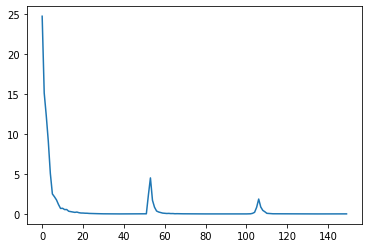

In [27]:
# Train
log_loss=[]

for epoch in range(epochs):
    total_loss = 0
    model_encoder.train()
    model_decoder.train()
    for batch, (data, data_s) in enumerate(train_loader):
        #print(data)
        data, data_s = data.to(device), data_s.to(device)
        
        optimizer_En.zero_grad()
        optimizer_De.zero_grad()
        # Forward
        codes = model_encoder(data)
        decoded = model_decoder(codes)
        
        target = torch.tensor(np.ones(dataset.vocab_size, dtype='float32'), dtype=torch.float)
        # print(data_s[50])
        loss = loss_function(decoded, data_s)
        loss.backward()
        
        optimizer_En.step()
        optimizer_De.step()
        
        total_loss+=loss
        
    #total_loss /= len(train_dataloader.dataset)
    log_loss.append(loss)
    print('[{}/{}] Loss:'.format(epoch+1, epochs), total_loss.item())
    if (epoch % 10 == 0) and (epoch != 0):
      torch.save(model_encoder.state_dict(), model_path+'_'+str(encoded_dim)+'_'+str(epoch)+config['dataset']+'_encoder.pth')
      torch.save(model_decoder.state_dict(), model_path+'_'+str(encoded_dim)+'_'+str(epoch)+config['dataset']+'_decoder.pth')
print('[{}/{}] Loss:'.format(epoch+1, epochs), total_loss.item())
plt.plot(log_loss)
torch.save(model_encoder.state_dict(), model_path+'_'+str(encoded_dim)+'_'+str(epoch)+config['dataset']+'_encoder.pth')
torch.save(model_decoder.state_dict(), model_path+'_'+str(encoded_dim)+'_'+str(epoch)+config['dataset']+'_decoder.pth')

In [34]:
def evaluate_sklearn(pred, ans):
    results = {}
        
    one_hot_ans = np.arange(ans.shape[0])[ans > 0]
    
    for topk in config["topk"]:
        one_hot_pred = np.argsort(pred)[-topk:]
        hit = np.intersect1d(one_hot_pred, one_hot_ans)
        percision = len(hit) / topk
        #print(percision)
        recall = len(hit) / len(one_hot_ans)
        #print(recall)
        f1 = 2 * percision * recall / (percision + recall) if (percision + recall) > 0 else 0
        
        results['F1@{}'.format(topk)] = f1
        
    ans = ans.reshape(1, -1)
    pred = pred.reshape(1, -1)
    for topk in config["topk"]:
        results['ndcg@{}'.format(topk)] = ndcg_score(ans, pred, k=topk)

    results['ndcg@all'] = (ndcg_score(ans, pred, k=None))
    
    return results

In [29]:
# evaluate all
for model_type in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 149]:
  model_encoder = Encoder(dataset.vocab_size, encoded_dim).to(device)
  model_decoder = Decoder(encoded_dim, dataset.vocab_size).to(device)
  model_encoder.load_state_dict(torch.load(model_path+'_'+str(encoded_dim)+'_'+str(model_type)+config['dataset']+'_encoder.pth'))
  model_decoder.load_state_dict(torch.load(model_path+'_'+str(encoded_dim)+'_'+str(model_type)+config['dataset']+'_decoder.pth'))
  model_encoder.eval()
  model_decoder.eval()
  results = []
  with torch.no_grad():
    for batch, (data, data_s) in enumerate(tqdm(test_loader)):
      codes = model_encoder(data.to(device))
      decoded = model_decoder(codes)
      for idx in range(len(data)):
        if sum(data[idx]) != 0:
          res = evaluate_sklearn(decoded[idx], data[idx])
          results.append(res)
  results_m = pd.DataFrame(results).mean()
  print('------'+str(model_type)+'------')
  print(results_m)
  print('-------------------------------')

  0%|          | 0/22 [00:00<?, ?it/s]

------10------
F1@10       0.093603
F1@30       0.194855
F1@50       0.260086
ndcg@10     0.281275
ndcg@30     0.308169
ndcg@50     0.357587
ndcg@all    0.543174
dtype: float64
-------------------------------


  0%|          | 0/22 [00:00<?, ?it/s]

------20------
F1@10       0.109746
F1@30       0.234196
F1@50       0.303485
ndcg@10     0.324280
ndcg@30     0.358351
ndcg@50     0.412869
ndcg@all    0.572708
dtype: float64
-------------------------------


  0%|          | 0/22 [00:00<?, ?it/s]

------30------
F1@10       0.114409
F1@30       0.239671
F1@50       0.309061
ndcg@10     0.335989
ndcg@30     0.368889
ndcg@50     0.424554
ndcg@all    0.579663
dtype: float64
-------------------------------


  0%|          | 0/22 [00:00<?, ?it/s]

------40------
F1@10       0.116105
F1@30       0.243481
F1@50       0.309829
ndcg@10     0.338135
ndcg@30     0.372546
ndcg@50     0.426765
ndcg@all    0.581426
dtype: float64
-------------------------------


  0%|          | 0/22 [00:00<?, ?it/s]

------50------
F1@10       0.118814
F1@30       0.245077
F1@50       0.310800
ndcg@10     0.341326
ndcg@30     0.374945
ndcg@50     0.428743
ndcg@all    0.582787
dtype: float64
-------------------------------


  0%|          | 0/22 [00:00<?, ?it/s]

------60------
F1@10       0.121720
F1@30       0.223590
F1@50       0.272987
ndcg@10     0.356183
ndcg@30     0.371287
ndcg@50     0.411233
ndcg@all    0.584724
dtype: float64
-------------------------------


  0%|          | 0/22 [00:00<?, ?it/s]

------70------
F1@10       0.119372
F1@30       0.226669
F1@50       0.275368
ndcg@10     0.353704
ndcg@30     0.373331
ndcg@50     0.412489
ndcg@all    0.584130
dtype: float64
-------------------------------


  0%|          | 0/22 [00:00<?, ?it/s]

------80------
F1@10       0.118330
F1@30       0.226958
F1@50       0.275995
ndcg@10     0.350798
ndcg@30     0.371150
ndcg@50     0.411179
ndcg@all    0.581899
dtype: float64
-------------------------------


  0%|          | 0/22 [00:00<?, ?it/s]

------90------
F1@10       0.118110
F1@30       0.227520
F1@50       0.275551
ndcg@10     0.349861
ndcg@30     0.370968
ndcg@50     0.410275
ndcg@all    0.581408
dtype: float64
-------------------------------


  0%|          | 0/22 [00:00<?, ?it/s]

------100------
F1@10       0.117311
F1@30       0.226732
F1@50       0.275560
ndcg@10     0.347876
ndcg@30     0.369433
ndcg@50     0.409105
ndcg@all    0.580264
dtype: float64
-------------------------------


  0%|          | 0/22 [00:00<?, ?it/s]

------110------
F1@10       0.123949
F1@30       0.229618
F1@50       0.279047
ndcg@10     0.355281
ndcg@30     0.373030
ndcg@50     0.413068
ndcg@all    0.585287
dtype: float64
-------------------------------


  0%|          | 0/22 [00:00<?, ?it/s]

------120------
F1@10       0.123500
F1@30       0.232452
F1@50       0.280445
ndcg@10     0.358194
ndcg@30     0.378068
ndcg@50     0.416794
ndcg@all    0.587272
dtype: float64
-------------------------------


  0%|          | 0/22 [00:00<?, ?it/s]

------130------
F1@10       0.123074
F1@30       0.232137
F1@50       0.279750
ndcg@10     0.357270
ndcg@30     0.377136
ndcg@50     0.415856
ndcg@all    0.586397
dtype: float64
-------------------------------


  0%|          | 0/22 [00:00<?, ?it/s]

------140------
F1@10       0.123016
F1@30       0.231876
F1@50       0.279535
ndcg@10     0.357381
ndcg@30     0.376949
ndcg@50     0.415761
ndcg@all    0.586365
dtype: float64
-------------------------------


  0%|          | 0/22 [00:00<?, ?it/s]

------149------
F1@10       0.119566
F1@30       0.229308
F1@50       0.279973
ndcg@10     0.349413
ndcg@30     0.370585
ndcg@50     0.411467
ndcg@all    0.582114
dtype: float64
-------------------------------


In [ ]:
# evaluate one
model_type=40
model_encoder = Encoder(dataset.vocab_size, encoded_dim).to(device)
model_decoder = Decoder(encoded_dim, dataset.vocab_size).to(device)
model_encoder.load_state_dict(torch.load(model_path+'_'+str(encoded_dim)+'_'+str(model_type)+config['dataset']+'_encoder.pth'))
model_decoder.load_state_dict(torch.load(model_path+'_'+str(encoded_dim)+'_'+str(model_type)+config['dataset']+'_decoder.pth'))
model_encoder.eval()
model_decoder.eval()
results = []
with torch.no_grad():
  for batch, (data, data_s) in enumerate(tqdm(train_loader)):
    codes = model_encoder(data.to(device))
    decoded = model_decoder(codes)
    #print(len(data))
    for idx in range(len(data)):
      if sum(data[idx]) != 0:
        res = evaluate_sklearn(decoded[idx], data[idx])
        results.append(res)
results_m = pd.DataFrame(results).mean()
print('------'+str(model_type)+'------')
print(results_m)
print('-------------------------------')

  0%|          | 0/86 [00:00<?, ?it/s]